In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
titles = open("../data/tangpoetry_titles.txt").read().split("\n")
print(titles[0:5])
print(len(titles))

['廣州王園寺伏日即事寄北中親友', '春日', '失題', '古意', '勗曹生']
40095


In [3]:
char_lists = []
for title in titles:
    char_lists.extend(list(title))
    
char_set_list = list(set(char_lists))

stoi = {c: i+2 for i, c in enumerate(char_set_list)}
stoi[" 《"] = 0
stoi["》 "] = 1
itos = {i: c for c, i in stoi.items()}

print("number of chars: ", len(stoi))

number of chars:  4246


In [4]:
import random
random.seed(42)
random.shuffle(titles)            

block_size = 3

def build_dataset(titles):
    X, Y = [], []
    
    for title in titles:
        context = [0] * block_size
        for c in list(title) + [itos[1]]:
            ic = stoi[c]
            # print("".join([itos[i].strip() for i in context]), " -----> ", c)
            X.append(context)
            Y.append(ic)
            context = context[1:] + [ic]
    X = torch.LongTensor(X)
    Y = torch.LongTensor(Y)    
    print(X.shape, Y.shape)
    return X, Y
            
n1 = int(len(titles) * 0.8)
n2 = int(len(titles) * 0.9)

Xtr, Ytr = build_dataset(titles[:n1])
Xva, Yva = build_dataset(titles[n1:n2])
Xte, Yte = build_dataset(titles[n2:])



torch.Size([240524, 3]) torch.Size([240524])
torch.Size([30220, 3]) torch.Size([30220])
torch.Size([30615, 3]) torch.Size([30615])


In [8]:
# MLP

n_embed = 30
n_hidden = 300

g = torch.Generator().manual_seed(42)
C = torch.randn(len(stoi), n_embed, generator=g)
W1 = torch.randn(n_embed * block_size, n_hidden, generator=g) * (5/3)/((n_embed * block_size)**0.5) # 0.01
# b1 = torch.randn(n_hidden, generator=g) * 0
W2 = torch.randn(n_hidden, len(stoi), generator=g) * 0.01
b2 = torch.randn(len(stoi), generator=g) * 0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))

bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

params = [C, W1, W2, b2, bngain, bnbias]
print(sum([p.numel() for p in params]))
for param in params:
    param.requires_grad = True

1433026


In [14]:
# cpu
lri, stepi, lossi = [], [], []

for i in range(20000):
    
    ix = torch.randint(0, len(Xtr), (128,))
    Xb, Yb = Xtr[ix], Ytr[ix]
    
    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    y = Ytr[ix]
    
    loss = F.cross_entropy(logits, y)
    for p in params:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 10000 else 0.01
    for p in params:
        p.data -= lr * p.grad
        
    lossi.append(loss.log10().mean().item())
    
    if i % 1000 == 0:
        print(str(i) + "/20000: " + str(loss.item()))

0/20000: 5.028063774108887
1000/20000: 4.426927089691162
2000/20000: 5.05516242980957
3000/20000: 5.04756498336792
4000/20000: 4.921078681945801
5000/20000: 4.822803020477295
6000/20000: 5.22685432434082
7000/20000: 4.495724201202393
8000/20000: 4.480425834655762
9000/20000: 5.020199298858643
10000/20000: 4.787585258483887
11000/20000: 4.480161190032959
12000/20000: 4.631681442260742
13000/20000: 4.631861209869385
14000/20000: 4.752414226531982
15000/20000: 4.958267688751221
16000/20000: 4.855884552001953
17000/20000: 4.652013301849365
18000/20000: 4.71656608581543
19000/20000: 4.41982364654541


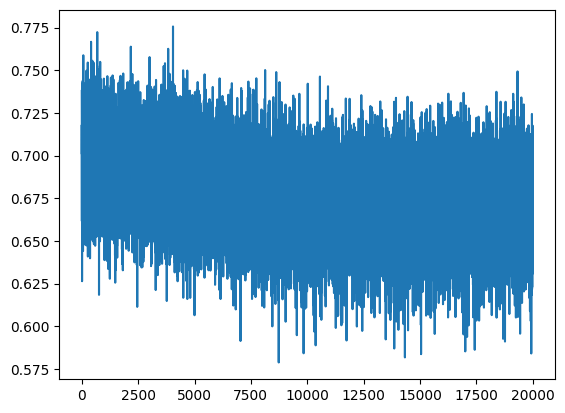

In [17]:
plt.plot(lossi)

In [18]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        "tr": (Xtr, Ytr),
        "va": (Xva, Yva),
        "te": (Xte, Yte)
    }[split]
    
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split + " loss: " + str(loss.item()))
    
split_loss("tr")
split_loss("va")

tr loss: 4.653635025024414
va loss: 5.062133312225342


In [20]:
context = [0] * block_size
C[torch.tensor([context])].shape
g = torch.Generator().manual_seed(42)

for _ in range(20):
    
    out = []
    ix = 0
    
    while True:
        embed = C[torch.tensor([context])].view(1, -1)
        hpreact = embed @ W1
        # hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
        hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
        h = torch.tanh(hpreact)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)  
        
        if ix == 1:
            break
        
    print("《" + "".join([itos[i].strip() for i in out]))

《李中曉》
《》
《》
《》
《》
《》
《》
《》
《》
《》
《》
《李殷丞遊人溪不遇》
《題亦粧寺陽酬子行》
《書人南溪》
《集長官》
《遊暮侍中感興》
《公》
《宗遊法戎歲邊北巘城中丞賦圖舃南樓夜與往李明府之》
《》
《》
